In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygad

import itertools
import random

from graph import Graph
from graphParser import parseGraph

In [3]:
# Load graph
from os.path import join
graph_in = "1-FullIns_4.col"
graph = parseGraph(join("graphs/", graph_in), delimiter=" ", skiprows=5)

Fitness functions

`conflict_fitness` - Takes the reciprocal of the number of vertices in conflict
`conflict_ratio_fitness` - One minus the ratio of vertices in conflict to total number of vertices
`optimizing_conflict_fitness` - Identical to `conflict_ratio_fitness` if a solution hasn't been found, otherwise it increases negatively with the number of colors used

In [4]:
#Fitness
def conflict_fitness(solution, solution_idx):
    #update graph
    graph.set_vertex_colors(solution)

    # compute the number of ajacent vertices that share a color
    incorrect_verteces = 0
    for v1, v2 in graph.get_adjacent_vertices():
        if graph.get_vertex_color(v1) == graph.get_vertex_color(v2):
            incorrect_verteces += 1

    return 1.0 / (incorrect_verteces + 1)

def conflict_ratio_fitness(solution, solution_idx):
    graph.set_vertex_colors(solution)
    return 1 - len(graph.get_vertices_in_conflict()) / graph.num_vertices

def optimizing_conflict_fitness(solution, solution_idx):
    graph.set_vertex_colors(solution)
    num_conflicts = graph.num_vertex_conflicts()
    if num_conflicts == 0:
        return 1 + (graph.num_vertices - len(set(solution)))
    else:
        return 1 - num_conflicts / graph.num_vertices

Mutations

`mutate_conflicted_vertices` - Mutates only vertices that are in conflict
`mutate_vertices` - Mutates any vertices

In [15]:
# Mutation
def mutate_conflicted_vertices(offspring, ga_instance):
    for chromosome_idx in range(offspring.shape[0]):
        # find vertices that are in conflict
        graph.set_vertex_colors(offspring[chromosome_idx, :])

        conflicts = graph.get_conflicted_vertex_pairs()

        #change one vertex from each conflict with mutation probabily
        for v1, _ in conflicts:
            if random.random() < ga_instance.mutation_probability:
                offspring[chromosome_idx, v1] = random.choice(ga_instance.gene_space)
    
    return offspring

temp_base = 10
temp_decay = 1
temp = temp_base
temp_decrease_coef = 0.2
from math import exp
def mutate_anealing(offspring, ga_instance):
    global temp
    for chromoseme_idx in range(offspring.shape[0]):
        graph.set_vertex_colors(offspring[chromoseme_idx, :])
        conflicts = graph.get_vertices_in_conflict()

        for i, v in enumerate(offspring[chromoseme_idx, :]):
            if v in conflicts:
                if random.random() <= ga_instance.mutation_probability:
                    offspring[chromoseme_idx, i] = random.choice(ga_instance.gene_space)
            else:
                if random.random() <= ga_instance.mutation_probability / ((ga_instance.generations_completed + 1)):
                    offspring[chromoseme_idx, i] = random.choice(ga_instance.gene_space)
    
    return offspring

def mutate_vertices(offspring, ga_instance):
    for chromoseme_idx in range(offspring.shape[0]):
        for i, v in enumerate(offspring[chromoseme_idx, :]):
            if random.random() <= ga_instance.mutation_probability:
                offspring[chromoseme_idx, i] = random.choice(ga_instance.gene_space)
    
    return offspring

Crossover

Crossover can't be performed at the genotype level, as there is no local correspondence between genes. We perform crossover by taking all the unconflicted vertices from one parent, and swapping them for all the corresponding vertices of the other one.

In [6]:
# Crossover
def uncoflicted_crossover(parents, offspring_size, ga_instance):
    offspring = []
    for parent in parents:
        offspring.append(parent[:].copy())
    idx = 0
    while len(offspring) != offspring_size[0]:
        if not (ga_instance.crossover_probability is None):
            probs = np.random.random(size=parents.shape[0])
            indices = np.where(probs <= ga_instance.crossover_probability)[0]
            # If no parent satisfied the probability, no crossover is applied and a parent is selected.
            if len(indices) == 0:
                # print(f'DEBUG: {parents[idx % parents.shape[0], :]}')
                offspring.append(parents[idx % parents.shape[0], :])
                continue
            elif len(indices) == 1:
                parent1_idx = indices[0]
                parent2_idx = parent1_idx
            else:
                indices = random.sample(set(indices), 2)
                parent1_idx = indices[0]
                parent2_idx = indices[1]
        else:
            parent1_idx = idx % parents.shape[0]
            parent2_idx = (idx + 1) % parents.shape[0]

        parent1 = parents[parent1_idx, :].copy()
        parent2 = parents[parent2_idx, :].copy()

        # random_split_point = np.random.choice(range(offspring_size[0]))
        graph.set_vertex_colors(parent1)
        conflicts = graph.get_vertices_in_conflict()

        parent1[conflicts] = parent2[conflicts]

        offspring.append(parent1)

        idx += 1
    
    return np.array(offspring)

In [7]:
last_fitness = 0
def callback_generation(ga_instance):
    global last_fitness
    change = ga_instance.best_solution()[1] - last_fitness
    # print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    if change > 0:
        print("Generation = {generation}".format(generation=ga_instance.generations_completed))
        print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
        print("Change     = {change}".format(change=change))
    last_fitness = ga_instance.best_solution()[1]

def callback_generation_anealing(ga_instance):
    global last_fitness
    global temp
    change = ga_instance.best_solution()[1] - last_fitness
    # # print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    # if change > 0:
    #     print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    #     print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    #     print("Change     = {change}".format(change=change))
    last_fitness = ga_instance.best_solution()[1]
    temp = temp_base / (ga_instance.generations_completed + 1)

def callback_start_anealing(ga_instance):
    global last_fitness
    global temp
    global temp_base
    
    last_fitness = 0
    temp = temp_base

def callback_stop(ga_instance, fitnesses):
    global last_fitness
    last_fitness = 0

In [18]:
experiment_name = f"{graph_in}_anealing_optim_1.1.0"
num_generations = 300
ga_args = {
    "num_generations":num_generations,
    "num_parents_mating":10,
    "fitness_func":optimizing_conflict_fitness,
    "crossover_type":uncoflicted_crossover,
    "mutation_type":mutate_anealing,
    "mutation_probability":0.8,
    "crossover_probability":0.2,
    "keep_parents":False,
    "sol_per_pop":100, 
    "num_genes":graph.num_vertices,
    "gene_type":int,
    "gene_space":range(0, graph.num_vertices),
    "on_generation":callback_generation_anealing,
    "on_start":callback_start_anealing,
    "on_stop":callback_stop,
    #"stop_criteria":["saturate_20"]
}

In [19]:
runs = 100

best_solutions = []
best_solutions_fitnesses = []
fitness_developments_raw = []
best_solution_generations = []

import time
for run in range(runs):
    try:
        T1 = time.time()
        ga_instance = pygad.GA(**ga_args)
        ga_instance.run()
        T2 = time.time()

        solution, solution_fitness, solution_idx = ga_instance.best_solution()

        best_solutions.append(solution)
        best_solutions_fitnesses.append(solution_fitness)
        # print(len(ga_instance.best_solutions_fitness))
        # print(ga_instance.best_solutions_fitness)
        fitness_developments_raw.append(ga_instance.best_solutions_fitness)
        best_solution_generations.append(ga_instance.best_solution_generation)

        print(f"{run=} T={T2-T1} | Best Fitness={solution_fitness}")
    except KeyboardInterrupt:
        print("Keyboard Interrupt")
        break

C:\Users\jakko\AppData\Local\Temp\ipykernel_17228\312788762.py:20: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  indices = random.sample(set(indices), 2)


run=0 T=207.42372226715088 | Best Fitness=68.0
run=1 T=207.74215865135193 | Best Fitness=71.0
run=2 T=217.96008014678955 | Best Fitness=69.0
run=3 T=208.9063630104065 | Best Fitness=68.0
run=4 T=207.58864855766296 | Best Fitness=69.0
run=5 T=212.83234095573425 | Best Fitness=67.0
run=6 T=205.69374084472656 | Best Fitness=70.0
run=7 T=208.37943577766418 | Best Fitness=69.0
run=8 T=210.89986395835876 | Best Fitness=70.0
run=9 T=209.69157719612122 | Best Fitness=68.0
run=10 T=214.88524961471558 | Best Fitness=69.0
run=11 T=213.6597490310669 | Best Fitness=68.0
run=12 T=208.08376097679138 | Best Fitness=68.0
run=13 T=215.3287091255188 | Best Fitness=68.0
run=14 T=206.26726412773132 | Best Fitness=68.0
run=15 T=206.78101706504822 | Best Fitness=70.0
run=16 T=211.62370109558105 | Best Fitness=68.0
run=17 T=206.6971743106842 | Best Fitness=71.0
run=18 T=245.61350011825562 | Best Fitness=69.0
run=19 T=335.9704911708832 | Best Fitness=68.0
run=20 T=287.7943980693817 | Best Fitness=67.0
run=21 T

In [20]:
#pad fitnesses in runs that ended early
from copy import deepcopy
fitness_developments = deepcopy(fitness_developments_raw)
for i, x in enumerate(fitness_developments):
    if (x_len := len(x)) < num_generations + 1:
        # print(f"{i=} {len(x)}")
        # print(f"{i=} {len(x + [x[-1]] * ((num_generations + 1) - x_len))}")
        x = x + [x[-1]] * (num_generations + 1 - x_len)
        fitness_developments[i] = x

def update_graph_count_conflicts (g, sol):
            g.set_vertex_colors(sol)
            return len(g.get_vertices_in_conflict())

df = pd.DataFrame(
    {
        "generation":best_solution_generations,
        "fitness": best_solutions_fitnesses,
        "conflicts": [update_graph_count_conflicts(graph, solution) for solution in best_solutions],
        "num_colors":[len(set(solution)) for solution in best_solutions]
    }
)

df["conflict_ratio"] = df["conflicts"] / graph.num_vertices
df["solution_found"] = df["fitness"] >= 1
df["solution_not_in_init_pop"] = df["generation"] != 1

Graph: |V|=93, |E|=593
Solution found in 64.0% runs
Conflicts: mean=0.0, std=0.0, mean ratio to vertices=0.0
Colors: mean=25.65625, std=1.25
       generation   fitness  conflicts  num_colors  conflict_ratio
count   64.000000  64.00000       64.0    64.00000            64.0
mean   188.812500  68.34375        0.0    25.65625             0.0
std     58.103322   1.25000        0.0     1.25000             0.0
min     78.000000  66.00000        0.0    23.00000             0.0
25%    140.250000  68.00000        0.0    25.00000             0.0
50%    193.500000  68.00000        0.0    26.00000             0.0
75%    226.750000  69.00000        0.0    26.00000             0.0
max    299.000000  71.00000        0.0    28.00000             0.0


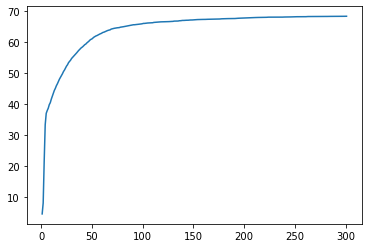

In [21]:
solution_count = df[df["solution_found"]].shape[0]
print(f"Graph: |V|={graph.num_vertices}, |E|={graph.num_edges}")
print(f"Solution found in {solution_count/runs * 100}% runs")
print(f"Conflicts: mean={df['conflicts'].mean()}, std={df['conflicts'].std()}, mean ratio to vertices={df['conflict_ratio'].mean()}")
print(f"Colors: mean={df['num_colors'].mean()}, std={df['num_colors'].std()}")
print(f"{df.describe()}")

# Plot fitness
fitness_developments = np.array(fitness_developments)

# print(fitness_developments)
_ = plt.plot(range(1, num_generations+1+1), fitness_developments.T.mean(axis=-1))

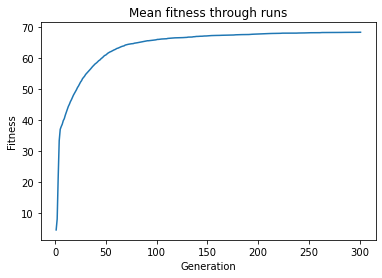

In [22]:
#save data
import os
import json
import csv


experiment_dir = f"./experiments_manual/{experiment_name}"
if not os.path.exists(experiment_dir):
    os.mkdir(experiment_dir)

params_fout_name = f"{experiment_name}_parameters.json"
results_fout_name = f"{experiment_name}_results.txt"
df_fout_name = f"{experiment_name}_data.csv"
fit_fout_name = f"{experiment_name}_fitness"
fit_plot_fout_name = f"{experiment_name}_mean_fit.png"

with open(os.path.join(experiment_dir, params_fout_name), 'w') as fout:
    serializable_args = {k : str(v) for k, v in ga_args.items()}
    serializable_args['runs'] = runs
    fout.write(json.dumps(serializable_args))
with open(os.path.join(experiment_dir, results_fout_name), 'w') as fout:
    solution_count = df[df["solution_found"]].shape[0]
    fout.write(f"Graph: |V|={graph.num_vertices}, |E|={graph.num_edges}\n")
    fout.write(f"Solution found in {solution_count/runs * 100}% runs\n")
    fout.write(f"Conflicts: mean={df['conflicts'].mean()}, std={df['conflicts'].std()}, mean ratio to vertices={df['conflict_ratio'].mean()}\n")
    fout.write(f"Colors: mean={df['num_colors'].mean()}, std={df['num_colors'].std()}\n")
    fout.write(f"{df.describe()}")
with open(os.path.join(experiment_dir, df_fout_name), 'w') as fout:
    df.to_csv(fout)
with open(os.path.join(experiment_dir, fit_fout_name), 'w') as fout:
    wr = csv.writer(fout)
    wr.writerows(fitness_developments)

# Plots
fig, ax = plt.subplots()

fitness_developments = np.array(fitness_developments)
ax.set(title='Mean fitness through runs', xlabel='Generation', ylabel='Fitness')
_ = ax.plot(range(1, num_generations+1+1), fitness_developments.T.mean(axis=-1))

fig.savefig(os.path.join(experiment_dir, fit_plot_fout_name))